# Bioconversion with Optimization

The first step is to select "Cell" > "Run All" from the toolbar.  This will initialize all the widgets and allow you to interact with the unit operation options via the GUI controls.

It looks like you're running this notebook on a laptop.
Operations requiring HPC resources will be disabled.


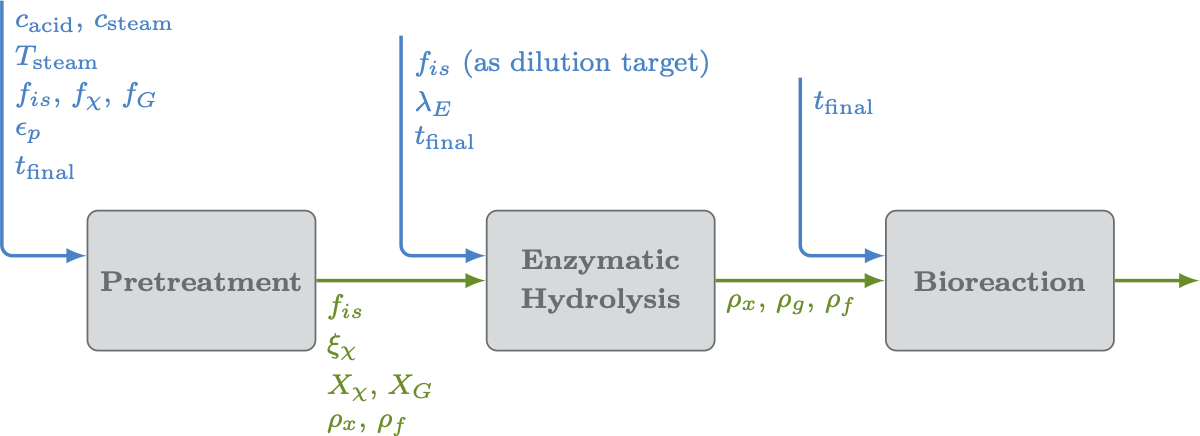

In [1]:
import os
import numpy as np
from ipywidgets import widgets

# imports from virteng modules
from virteng.WidgetFunctions import csv2widget_collection
from virteng.OptimizationFunctions import Optimization
from virteng.Utilities import get_host_computer

hpc_run = get_host_computer()  # See if we're running on Eagle or on a laptop

from IPython.display import Image, HTML, clear_output
Image(os.path.join(os.path.dirname("__file__"), 'figures', 'three_unit_flow.png'), width=800)

## Load Virtual Engineering Options

In [2]:
# Get default feedstock properties from file
fs_options = csv2widget_collection("./default_params/feedstock_params.csv")
fs_options.display_all_widgets()

In [3]:
# Get default pretreatment properties from file
pt_options = csv2widget_collection("./default_params/pretreatment_params.csv")
pt_options.display_all_widgets()

In [4]:
# Get default enzymatic hydrolysis properties from file
eh_options = csv2widget_collection("./default_params/enzymatic_hydrolysis_params.csv")
eh_options.display_all_widgets()

In [5]:
# Get default bioreactor properties from file
br_options = csv2widget_collection("./default_params/bioreactor_params.csv")
br_options.display_all_widgets()

---

## Choosing objective for optimization

In [6]:
obj_widget = widgets.Dropdown(
    options=[('Biorector:            OUR',   ('br_out', 'our')), 
             ('Enzymatic Hydrolysis: rho_g', ('eh_out', 'rho_g')), 
             ('Enzymatic Hydrolysis: rho_x', ('eh_out', 'rho_x')),
             ('Enzymatic Hydrolysis: rho_sL',('eh_out', 'rho_sL')),
             ('Enzymatic Hydrolysis: rho_f', ('eh_out', 'rho_f')),
             ('Pretreatment:         fis_0', ('eh_out', 'fis_0')),
             ('Pretreatment:         X_X',   ('eh_out', 'X_X')),
             ('Pretreatment:         X_G',   ('eh_out', 'X_G')),
             ('Pretreatment:         rho_x', ('eh_out', 'rho_x')),
             ('Pretreatment:         rho_f', ('eh_out', 'rho_f'))
            ],
    value=('br_out', 'our'),
    description='Objective:',
    tooltip = 'Specifies the objective to use in optimization.'
)

display(obj_widget)

Dropdown(description='Objective:', options=(('Biorector:            OUR', ('br_out', 'our')), ('Enzymatic Hydr…

---

## Parameter Sweeps

In [7]:
#================================================================
sweep_button = widgets.Button(
    description = 'Run Sweep.',
    tooltip = 'Execute the model start-to-finish with the properties specified above.',
    layout =  {'width': '200px', 'margin': '25px 0px 100px 170px'}, 
    button_style = 'primary'
)
#================================================================
display(sweep_button)
#================================================================
# Define a function to be executed each time the run button is pressed
def sweep_button_action(b):
    clear_output()
    display(sweep_button)
    Opt = Optimization(case_folder='./', options_list=[fs_options, pt_options, eh_options, br_options], obj_widjet=obj_widget, hpc_run=hpc_run)
    Opt.parameter_grid_sweep(nn=10, results_file='sweep_params.csv')
    
sweep_button.on_click(sweep_button_action)
#===============================================================

Button(button_style='primary', description='Run Sweep.', layout=Layout(margin='25px 0px 100px 170px', width='2…

Objective "our" is in br_out.
On each iteration running n=3 models

Initializing Pretreatment Model
Initializing Enzymatic Hydrolysis Model
Initializing Bioreactor Model
Optimizing Acid Loading.
Optimizing Enzymatic Load.


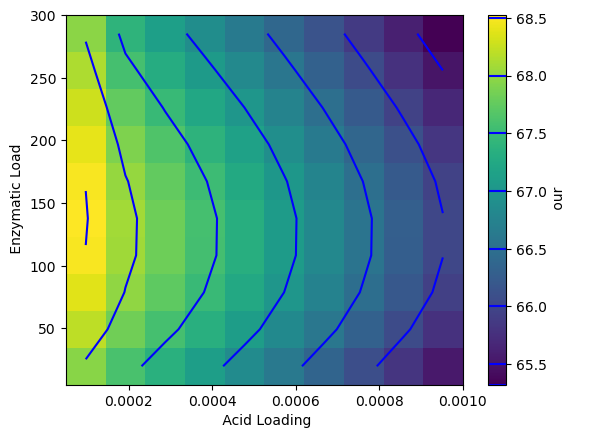

In [8]:
import matplotlib.pyplot as plt

param_sweep_fn = 'sweep_params.csv'
if os.path.exists(param_sweep_fn):
    with open(param_sweep_fn, 'r') as f:
        firstline = f.readline().split(',')
    Opt = Optimization(case_folder='./', options_list=[fs_options, pt_options, eh_options, br_options], obj_widjet=obj_widget, hpc_run=hpc_run)
    sweeps = np.loadtxt(param_sweep_fn, delimiter=',', skiprows=1)
    bounds = Opt.var_real_bounds
    extent = bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]
    nn = int(np.sqrt(len(sweeps)))
    OUR = sweeps[:, 3].reshape(nn, nn)
    shw = plt.imshow(OUR.T, extent=extent, aspect='auto', origin='lower')
    _cs2 = plt.contour(OUR.T, levels=np.arange(65, 69, 0.5), extent=extent, origin='lower', colors='blue')
    bar = plt.colorbar(shw)
    bar.add_lines(_cs2)
    bar.set_label(firstline[-1])
    plt.xlabel(firstline[1])
    plt.ylabel(firstline[2])

## Optimization

Press the Optimize button below to launch the optimization of the start-to-finish operation using the above values as initial conditions.

This example **maximizes OUR** by **changing user-specified control options**.

In [9]:
opt_button = widgets.Button(
    description = 'Optimize.',
    tooltip = 'Optimize for OUR using the conditions above as an initial guess.',
    layout =  {'width': '200px', 'margin': '25px 0px 25px 170px'}, 
    button_style = 'warning'
)
display(opt_button)
#================================================================
# Define a function to be executed each time the run button is pressed
def opt_button_action(b):
    clear_output()
    display(opt_button)
    
    Opt = Optimization(case_folder='./', options_list=[fs_options, pt_options, eh_options, br_options], obj_widjet=obj_widget, hpc_run=hpc_run)
    opt_result = Opt.scipy_minimize(Opt.objective_function, opt_results_file='optimization_results.csv')
    print(opt_result)
    
opt_button.on_click(opt_button_action)
#================================================================

Button(button_style='warning', description='Optimize.', layout=Layout(margin='25px 0px 25px 170px', width='200…

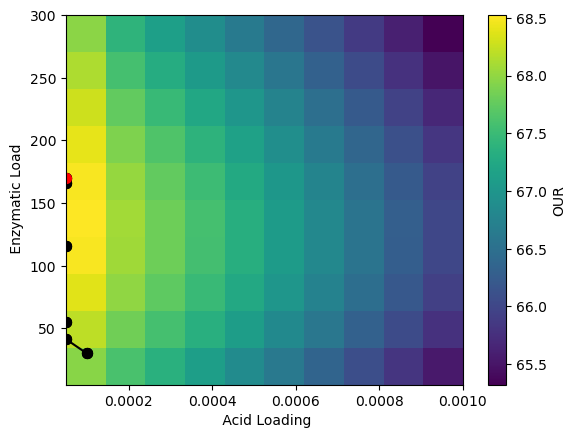

In [10]:
opt_results = np.loadtxt('optimization_results.csv', delimiter=',', skiprows=1)
shw = plt.imshow(OUR.T, extent=extent, aspect='auto', origin='lower')
bar = plt.colorbar(shw)
bar.set_label('OUR')
plt.xlabel(firstline[1])
plt.ylabel(firstline[2])
plt.scatter(opt_results[:, 1], opt_results[:, 2], s=50, c='k', marker='o')
plt.plot(opt_results[:, 1], opt_results[:, 2], color='k')
plt.scatter(opt_results[-1, 1], opt_results[-1, 2], s=50, c='r', marker='o')

---

In [11]:
a = HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" \
value="Toggle code visibility (hidden by default)."></form>''')

display(a)